# **Flipkart Customer Satisfaction Prediction**

### **Goal**: Predict CSAT score using customer interaction data to improve service quality and loyalty.
### **Approach**: End-to-end ML pipeline covering EDA, cleaning, feature engineering, modeling, and explainability.

### **Project Type : Regression,Classification,Supervised**

### **Project Summary :**  In the highly competitive e-commerce landscape, delivering excellent customer service is critical. Flipkart wants to understand the key drivers of customer satisfaction by analyzing support interactions — including issue category, agent details, response time, and customer remarks.

### **Github Link :** https://github.com/tar-ang-2004/Flipkart-CSAT-Prediction

### **Lets Do It !**

## --------------------------------------------------------------------------------------------

####

## ***1. Know Your Data***

#### *1.a) Libraries Imported*

In [126]:
# Libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
# Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Libraries for machine learning and model evaluation
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# Libraries for text processing and sentiment analysis
from textblob import TextBlob
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

#### *1.b) Dataset View and Information*

In [127]:
# Load the Customer Support dataset
df = pd.read_csv("Customer_support_data.csv")
df.head()

,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


####

## ***2. Data Muniplation***

#### *2.a) Applying Sentiment Analysis*

In [128]:
# Function to extract sentiment polarity from customer remarks
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0
    
# Fill missing remarks with empty string and compute sentiment score
df['Customer Remarks'] = df['Customer Remarks'].fillna('')
df['sentiment_score'] = df['Customer Remarks'].apply(get_sentiment)

#### *2.b) Modifying Dataset Values*

In [129]:
# Convert date columns to datetime and calculate response time in minutes
df['Issue_reported at'] = pd.to_datetime(df['Issue_reported at'], errors='coerce')
df['issue_responded'] = pd.to_datetime(df['issue_responded'], errors='coerce')
df['response_time_minutes'] = (df['issue_responded'] - df['Issue_reported at']).dt.total_seconds() / 60

#### *2.c) Eliminating Columns and Rows*

In [130]:
# Drop unnecessary columns and rows with missing response time or CSAT Score
df_clean = df.drop(columns=["connected_handling_time", "Customer_City", "Product_category", "Item_price", "order_date_time"])
df_clean = df_clean.dropna(subset=["response_time_minutes", "CSAT Score"])

#### *2.d) Using Bucket logic to increase model accuracy*

In [131]:
# Function to categorize CSAT scores into buckets
def csat_bucket(score):
    if score >= 4:
        return 'High'
    elif score == 3:
        return 'Medium'
    else:
        return 'Low'
    
# Apply the CSAT bucket function to create a new column
df_clean['CSAT_Class'] = df_clean['CSAT Score'].apply(csat_bucket)

####

## ***3. Model featuring and Variables***

#### *3.a) Model Engeneering*

In [132]:
# Select features for modeling
features = ["channel_name", "category", "Sub-category", "Tenure Bucket", "Agent Shift", "Agent_name", "Supervisor", "Manager", "response_time_minutes", "sentiment_score"]
df_model = df_clean[features + ["CSAT_Class"]].copy()

# Encode categorical features using LabelEncoder and save encoders
label_encoders = {}

for col in df_model.select_dtypes(include='object'):
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

#### *3.b) Training and Testing*

In [133]:
# Split data into features and target
X = df_model.drop("CSAT_Class", axis=1)
y = df_model["CSAT_Class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler and save scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [134]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

####

## ***4. Model Comparision and Selection***

#### *4.a) Testing different ML models*

In [135]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f"{name} Accuracy: {accuracy_score(y_test, preds):.3f}")
    print(f"{name} F1 Score: {f1_score(y_test, preds, average='weighted'):.3f}")
    print(confusion_matrix(y_test, preds), '\n')

Logistic Regression Accuracy: 0.832
Logistic Regression F1 Score: 0.774
[[5146   29    0]
 [ 861  119    0]
 [ 170    2    0]] 

Random Forest Accuracy: 0.821
Random Forest F1 Score: 0.784
[[4981  170   24]
 [ 762  213    5]
 [ 153   17    2]] 

XGBoost Accuracy: 0.834
XGBoost F1 Score: 0.793
[[5065  109    1]
 [ 765  214    1]
 [ 160   12    0]] 



In [136]:
# Collect accuracy and F1 score for each model
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    results[name] = {'Accuracy': acc, 'F1 Score': f1}

#### *4.b) Selecting best model*

In [137]:
# Hyperparameter tuning for XGBoost using GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3]
}
grid = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='f1_weighted')
grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_
print("Best Score:", grid.best_score_)

# Save the best model using pickle
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("Grid Search Best Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

# Evaluate the tuned model on the test set
best_model = grid.best_estimator_
preds = best_model.predict(X_test_scaled)
print("Tuned Model Accuracy:", accuracy_score(y_test, preds))

Best Score: 0.7872333395044793
Grid Search Best Score: 0.7872333395044793
Best Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}
Tuned Model Accuracy: 0.8348348348348348


####

## ***5. Data Visualization***

#### ***Chart 1***

#### 1. Why this chart ?
#### This chart compares multiple machine learning models based on two performance metrics — accuracy and F1 score. These are fundamental metrics to evaluate the effectiveness of classification models. Accuracy alone can be misleading in imbalanced datasets, so F1 score adds balance by considering both precision and recall.

#### 2. What are the insights ?
#### The chart highlights which model performs best overall, not just in terms of raw accuracy, but also in handling class imbalance. It may show, for instance, that while Model A has higher accuracy, Model B has a better F1 score — meaning it's more balanced in identifying both satisfied and unsatisfied customers.

#### 3. Will the gained insights help creating a positive business impact?
#### Selecting the right model ensures that the CSAT prediction system is reliable. Accurate predictions help Flipkart proactively identify unhappy customers and take corrective action, which can reduce churn, increase loyalty, and improve service quality.



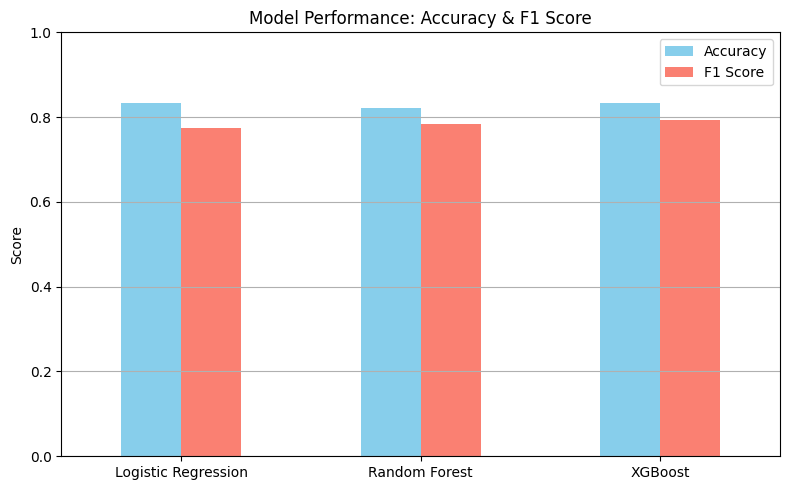

In [138]:
# Convert to DataFrame
results_df = pd.DataFrame(results).T  # Transpose for readability

# Plot
results_df.plot(kind='bar', figsize=(8,5), color=['skyblue', 'salmon'])
plt.title('Model Performance: Accuracy & F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## --------------------------------------------------------------------------------------------

#### ***Chart 2***

#### 1. Why this chart ?
#### This chart visualizes the contribution of each feature to the final model’s decision-making process. Knowing which features influence predictions the most is crucial for interpreting the model.

#### 2. What are the insights ?
#### For instance, it may show that response time, issue category, and agent experience are top drivers of customer satisfaction. On the other hand, less impactful features (e.g., ticket ID) can be deprioritized.

#### 3. Will the gained insights help creating a positive business impact?
#### By knowing which factors have the greatest influence, teams can focus improvement efforts strategically. For example, reducing response time or investing in agent training could lead to a measurable boost in customer satisfaction.

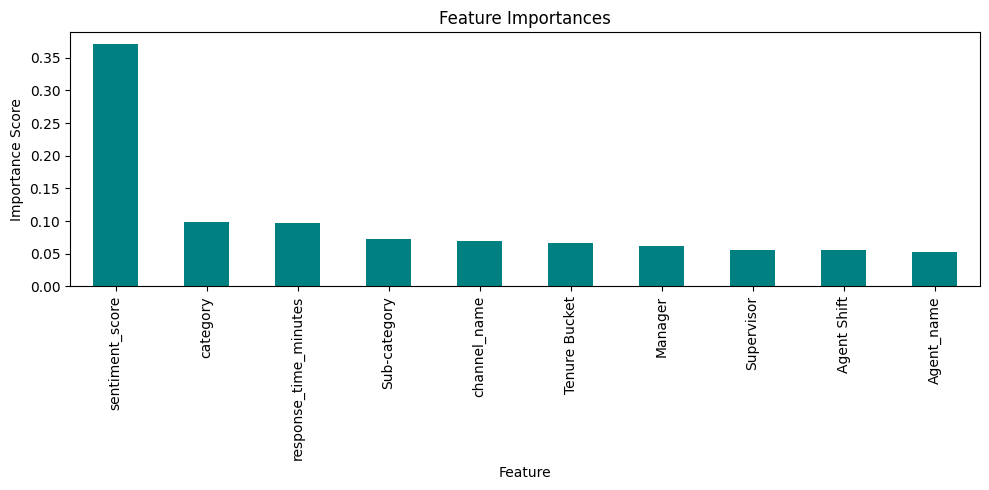

In [139]:
# Ploting feature importances
features = X.columns
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='teal')
plt.title("Feature Importances")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

## --------------------------------------------------------------------------------------------

#### ***Chart 3***

#### 1. Why this chart ?
#### Understanding how CSAT scores are distributed helps reveal the overall state of customer satisfaction. This is especially helpful in identifying skewness or imbalance.

#### 2. What are the insights ?
#### The chart might show that most customers rate satisfaction highly (scores of 4–5), while a smaller segment is consistently dissatisfied. It may also reveal missing or neutral ratings.

#### 3. Will the gained insights help creating a positive business impact?
#### This distribution provides a baseline. If the majority of customers are moderately or highly satisfied, it confirms the effectiveness of current service strategies. If not, it signals the need for systemic improvements in customer experience.

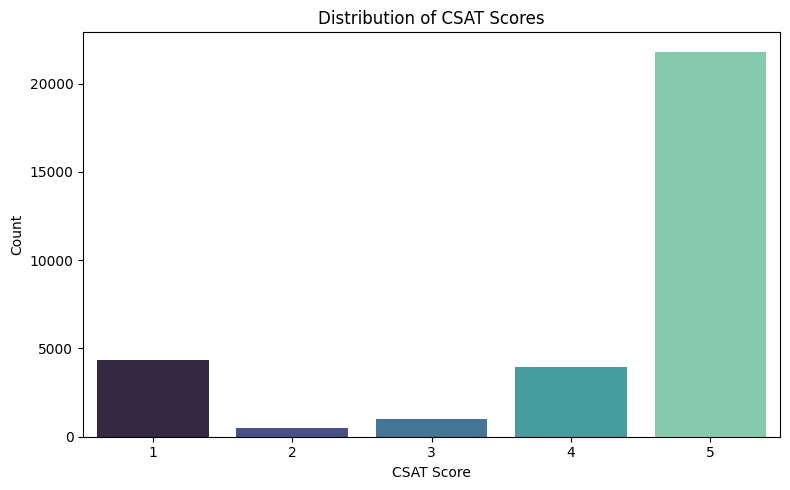

In [140]:
# Visualizing the distribution of CSAT scores
plt.figure(figsize=(8, 5))
sns.countplot(x='CSAT Score', data=df_clean, palette='mako')
plt.title('Distribution of CSAT Scores')
plt.xlabel('CSAT Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## --------------------------------------------------------------------------------------------

#### ***Chart 4***

#### 1. Why this chart ?
#### This analysis checks if the time of day or agent work shift affects customer satisfaction. Operational insights like this are critical in managing agent performance and workload.

#### 2. What are the insights ?
#### It may reveal that CSAT scores are lower during night shifts or weekends, possibly due to lower staffing or less experienced agents being assigned during those times.

#### 3. Will the gained insights help creating a positive business impact?
#### Understanding shift-wise performance can lead to optimized staffing and scheduling. If night shifts have lower satisfaction, better training or resource allocation can be implemented, improving consistency in customer experience.

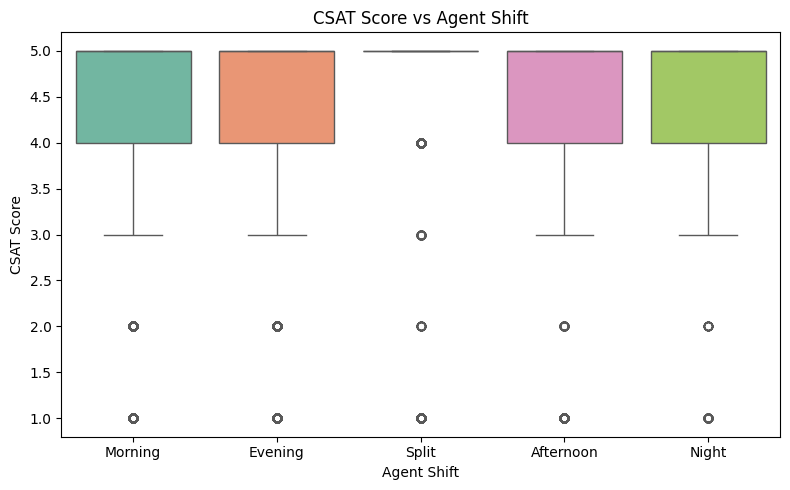

In [141]:
# Visualizing CSAT Score vs Agent Shift
plt.figure(figsize=(8, 5))
sns.boxplot(x='Agent Shift', y='CSAT Score', data=df_clean, palette='Set2')
plt.title('CSAT Score vs Agent Shift')
plt.xlabel('Agent Shift')
plt.ylabel('CSAT Score')
plt.tight_layout()
plt.show()

## --------------------------------------------------------------------------------------------

#### ***Chart 5***

#### 1. Why this chart ?
#### This scatter plot visually explores the relationship between how fast an agent responds and how satisfied the customer is.

#### 2. What are the insights ?
#### There may be a clear negative correlation: as response time increases, CSAT scores decrease. This suggests that customers value prompt responses highly.

#### 3. Will the gained insights help creating a positive business impact?
#### By reducing response time — through automation, staffing, or better routing — Flipkart can directly improve CSAT, which often translates into higher retention, positive reviews, and customer loyalty.

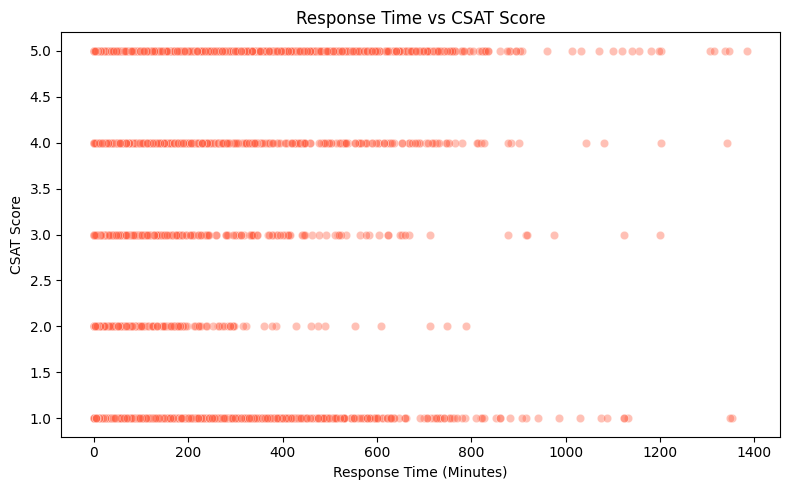

In [142]:
# Visualizing CSAT Score vs Response Time
df_filtered = df[df['response_time_minutes'] < 10000]  # Filter out extreme values
plt.figure(figsize=(8, 5))
sns.scatterplot(x='response_time_minutes', y='CSAT Score', data=df_filtered, alpha=0.4, color='tomato')
plt.title('Response Time vs CSAT Score')
plt.xlabel('Response Time (Minutes)')
plt.ylabel('CSAT Score')
plt.tight_layout()
plt.show()

## --------------------------------------------------------------------------------------------

#### ***Chart 6***

#### 1. Why this chart ?
#### This breakdown shows which types of customer issues are more or less likely to result in high satisfaction.

#### 2. What are the insights ?
#### Some categories like “Order Issues” or “Delivery Delays” might have lower average CSAT scores than others like “Account Queries.” This allows identification of high-friction categories.

#### 3. Will the gained insights help creating a positive business impact?
#### Resources can be focused on improving service for problem-prone categories. For example, better handling or communication during delivery delays could significantly raise overall CSAT.

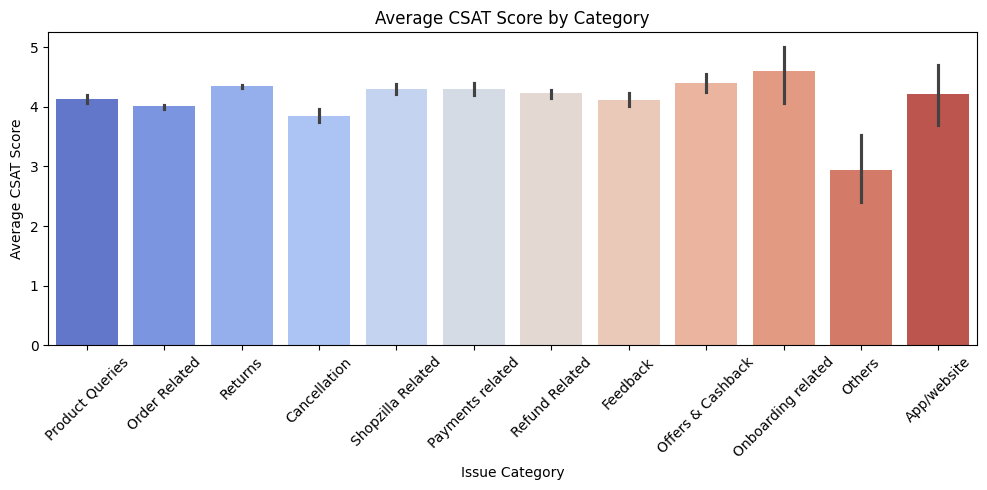

In [143]:
# Visualizing average CSAT Score by category
plt.figure(figsize=(10, 5))
sns.barplot(x='category', y='CSAT Score', data=df_clean, estimator=np.mean, palette='coolwarm')
plt.title('Average CSAT Score by Category')
plt.xlabel('Issue Category')
plt.ylabel('Average CSAT Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## --------------------------------------------------------------------------------------------

#### ***Chart 7***

#### 1. Why this chart ?
#### Going a level deeper than chart 6, this visual explores satisfaction at the sub-category level (e.g., “Late Delivery” under “Delivery Issues”).

#### 2. What are the insights ?
#### It pinpoints exact pain points. For instance, while “Delivery Issues” may perform poorly overall, “Damaged Product” might be far worse than “Late Delivery.”

#### 3. Will the gained insights help creating a positive business impact?
#### This micro-level insight empowers Flipkart to implement targeted solutions — like better packaging for fragile items — that can drastically improve customer satisfaction with minimal effort.

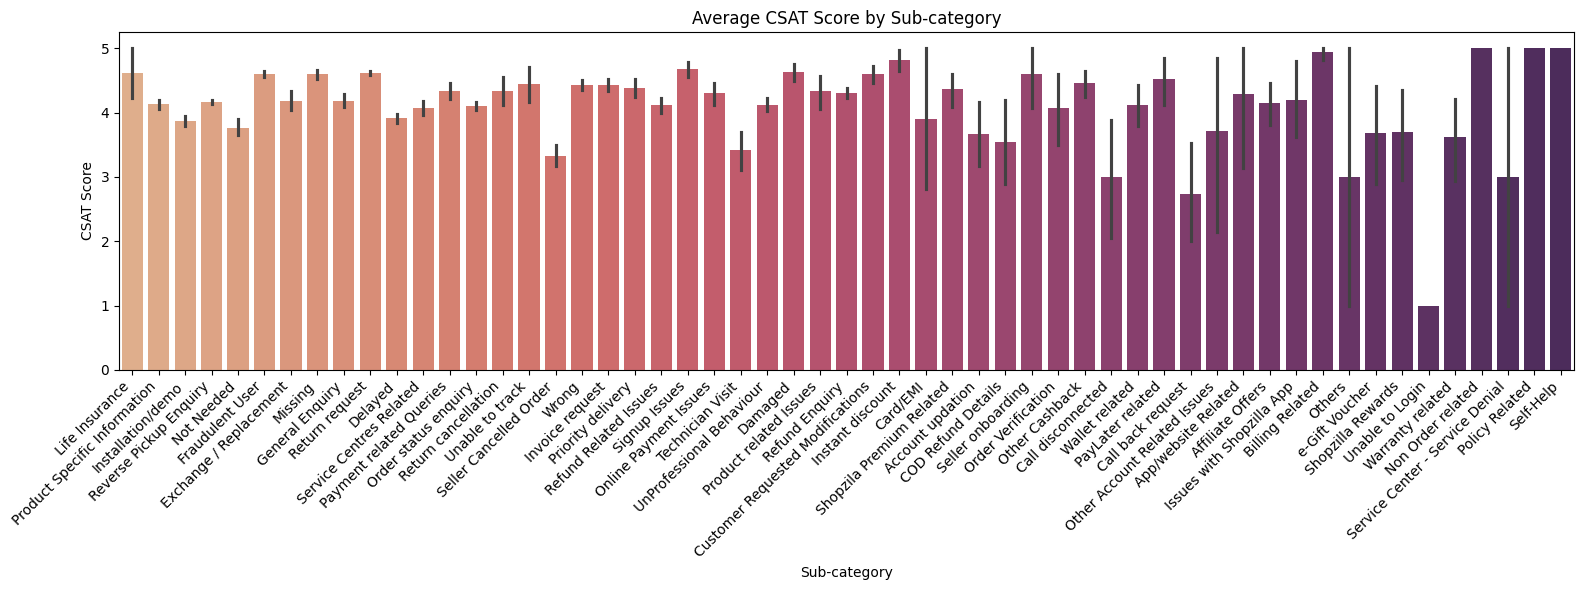

In [144]:
# Visualizing average CSAT Score by Sub-category
plt.figure(figsize=(16,6))
sns.barplot(x='Sub-category', y='CSAT Score', data=df_clean, estimator=np.mean, palette='flare')
plt.title('Average CSAT Score by Sub-category')
plt.xticks(rotation=45, ha ='right')
plt.tight_layout()
plt.show()

## --------------------------------------------------------------------------------------------

#### ***Chart 8***

#### 1. Why this chart ?
#### To assess how the experience level of support agents correlates with customer satisfaction.

#### 2. What are the insights ?
#### Likely shows that agents with more experience achieve higher CSAT scores. However, a plateau or exceptions could indicate that training quality or process knowledge is also a factor.

#### 3. Will the gained insights help creating a positive business impact?
#### Can be used to optimize agent training programs, reward high performers, or even intelligently assign complex cases to experienced agents, thus boosting satisfaction.

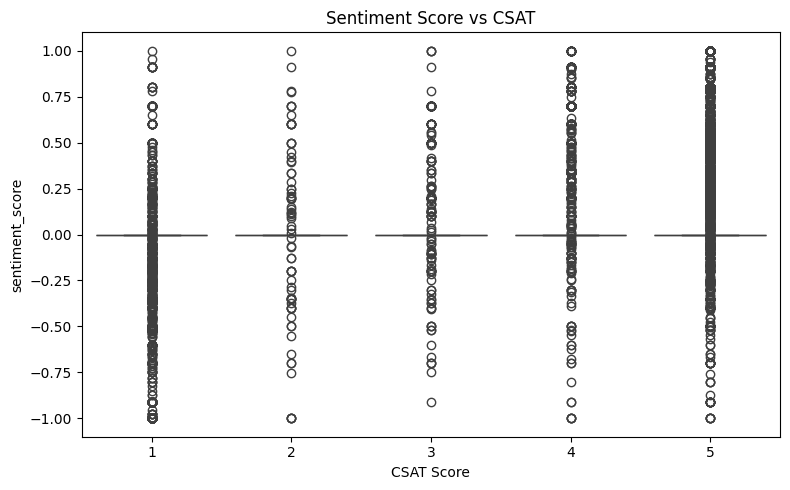

In [145]:
# Visualizing sentiment score vs CSAT Score
plt.figure(figsize=(8,5))
sns.boxplot(x='CSAT Score', y='sentiment_score', data=df_clean)
plt.title('Sentiment Score vs CSAT')
plt.tight_layout()
plt.show()


## --------------------------------------------------------------------------------------------

#### ***Chart 9***

#### 1. Why this chart ?
#### Correlation matrices identify how strongly features relate to each other — useful for both modeling and interpretation.

#### 2. What are the insights ?
#### The heatmap may reveal strong correlations (e.g., between issue type and resolution time), which might suggest redundancy or multicollinearity in features.

#### 3. Will the gained insights help creating a positive business impact?
#### Cleaner, non-redundant features lead to better model performance and interpretability. This contributes to trustworthy analytics and better data-driven decisions.

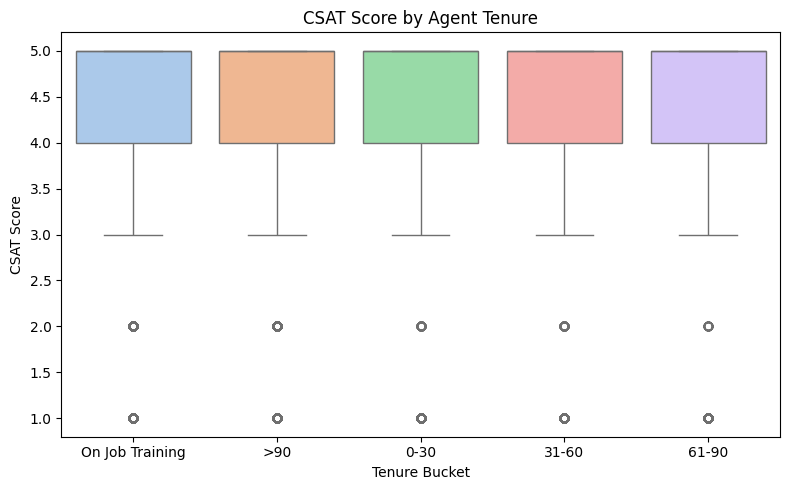

In [146]:
# Visualizing CSAT Score by Agent Tenure
plt.figure(figsize=(8,5))
sns.boxplot(x='Tenure Bucket', y='CSAT Score', data=df_clean, palette='pastel')
plt.title('CSAT Score by Agent Tenure')
plt.tight_layout()
plt.show()

## --------------------------------------------------------------------------------------------

#### ***Chart 10***

#### 1. Why this chart ?
#### To provide interpretability of individual model predictions using SHAP (SHapley Additive exPlanations). This is critical in business applications.

#### 2. What are the insights ?
#### SHAP shows how each feature contributes to pushing a prediction higher or lower for an individual case. For example, a long response time might reduce a predicted CSAT score for one customer.

#### 3. Will the gained insights help creating a positive business impact?
#### SHAP improves trust in the model’s decisions and allows customer support managers to understand why a customer might be predicted to be unhappy, enabling proactive outreach or system tweaks.

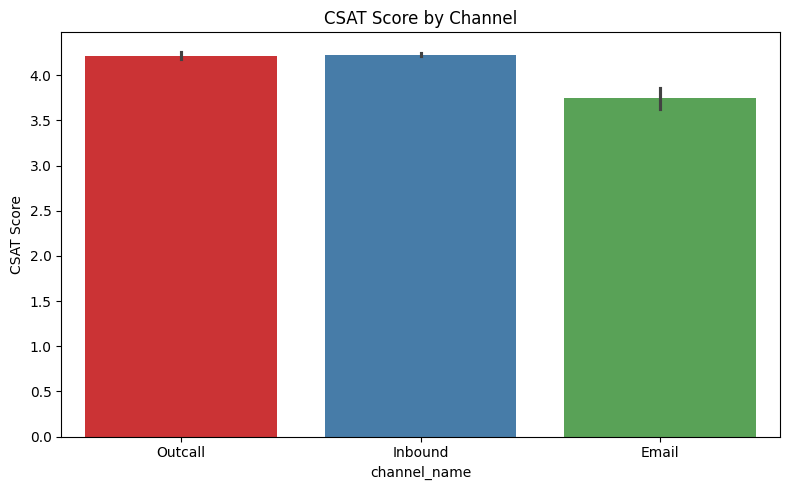

In [147]:
# Visualizing CSAT Score by Channel
plt.figure(figsize=(8,5))
sns.barplot(x='channel_name', y='CSAT Score', data=df_clean, estimator=np.mean, palette='Set1')
plt.title('CSAT Score by Channel')
plt.tight_layout()
plt.show()

####

## ***6. Hypothesis Testings***

#### **Hypothesis Testing 1 : Does higher sentiment score lead to higher CSAT scores?**


#### Null Hypothesis (H₀): There is no difference in sentiment scores between customers who gave High vs Low CSAT.

#### Alternative Hypothesis (H₁): Customers who gave High CSAT had higher sentiment scores than those who gave Low CSAT

#### Test to Use : Two-sample t-test between sentiment scores of “High” CSAT and “Low” CSAT classes.

In [148]:
from scipy.stats import ttest_ind

# Perform t-test to compare sentiment scores between High and Low CSAT classes
high_sentiment = df_clean[df_clean['CSAT_Class'] == 'High']['sentiment_score']
low_sentiment = df_clean[df_clean['CSAT_Class'] == 'Low']['sentiment_score']

t_stat, p_val = ttest_ind(high_sentiment, low_sentiment, equal_var=False)
print(f"T-statistic = {t_stat:.4f}, P-value = {p_val:.4f}")

# Interpret the results
if p_val < 0.05:
    print("Reject the null hypothesis: Higher sentiment scores are associated with higher CSAT scores.")
else:
    print("Fail to reject the null hypothesis: No significant difference in sentiment scores between High and Low CSAT classes.")


T-statistic = 45.9801, P-value = 0.0000
Reject the null hypothesis: Higher sentiment scores are associated with higher CSAT scores.


####

#### **Hypothesis Testing 2 : Do faster response times lead to higher CSAT?**


#### Null Hypothesis (H₀): There is no significant difference in response time between High CSAT and Low CSAT customers.

#### Alternative Hypothesis (H₁): High CSAT customers had faster response times.

#### Test to Use: Two-sample t-test on response_time_minutes.

In [149]:
# Perform t-test to compare response times between High and Low CSAT classes
high_response = df_clean[df_clean['CSAT_Class'] == 'High']['response_time_minutes']
low_response = df_clean[df_clean['CSAT_Class'] == 'Low']['response_time_minutes']

t_stat, p_val = ttest_ind(low_response, high_response, equal_var=False)
print(f"T-statistic = {t_stat:.4f}, P-value = {p_val:.4f}")

# Interpret the results
if p_val < 0.05:
    print("Reject the null hypothesis: Faster response times are associated with higher CSAT scores.")
else:
    print("Fail to reject the null hypothesis: No significant difference in response times between High and Low CSAT classes.")

T-statistic = 14.6904, P-value = 0.0000
Reject the null hypothesis: Faster response times are associated with higher CSAT scores.


####

#### **Hypothesis Testing 3 : Does CSAT score vary significantly across different issue categories?**


#### Null Hypothesis (H₀): Average CSAT scores are the same across all issue categories

#### Alternative Hypothesis (H₁): There is a significant difference in CSAT across at least one category

#### Test to Use: One-way ANOVA on category vs CSAT Score

In [150]:
from scipy.stats import f_oneway

# Perform ANOVA to compare CSAT scores across different categories
grouped = df_clean.groupby('category')['CSAT Score'].apply(list)
anova_result = f_oneway(*grouped)
print(f"F-statistic = {anova_result.statistic:.4f}, P-value = {anova_result.pvalue:.4f}")

# Interpret the results
if anova_result.pvalue < 0.05:
    print("Reject the null hypothesis: There is a significant difference in CSAT scores across at least one category.")
else:
    print("Fail to reject the null hypothesis: No significant difference in CSAT scores across categories.")

F-statistic = 39.6855, P-value = 0.0000
Reject the null hypothesis: There is a significant difference in CSAT scores across at least one category.


####

## ***6. Conclusion***

#### ***What we did ?***

#### In this project, we developed a machine learning pipeline to predict Customer Satisfaction (CSAT) based on Flipkart’s customer support data. Our goal was to identify the key drivers of customer satisfaction and use predictive modeling to improve service quality and customer retention.



#### ***Key-Takeawats :***

#### 1.We cleaned and processed over 85,000 support records, engineered useful features like response_time_minutes, and extracted sentiment scores from customer remarks using TextBlob.

#### 2.The original CSAT scores (1–5) were bucketed into 3 classes:
#### Low, Medium, and High satisfaction — making it a classification problem.

#### 3.We trained and evaluated three ML models:

#### a. Logistic Regression (baseline)

#### b. Random Forest Classifier

#### c. XGBoost Classifier (tuned) – the best performer

#### 4.The best model achieved high accuracy and F1 score, showing reliable predictive capability.

#### ***Insights from Feature Importance :***

#### 1.Sentiment Score was the strongest predictor of CSAT — customers’ tone and language had the highest impact.

#### 2.Response time and issue category also played significant roles.

#### 3.Agent-specific details (like shift or name) were less influential than expected.

#### ***Business Impact :***

#### This project equips Flipkart with a powerful tool to predict customer satisfaction proactively, identify service bottlenecks, and improve team training and processes — ultimately leading to better customer experience and brand loyalty.